<a href="https://colab.research.google.com/github/Pengyu-gis/Environmental_Hazard_Course_Final/blob/main/GEE_NDVI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install osmnx


In [5]:
# Import libraries
import ee
import geemap
import geopandas as gpd
import osmnx as ox
import matplotlib.pyplot as plt
import folium

# Authenticate and initialize Earth Engine
ee.Authenticate()
ee.Initialize(project='your-project-id')  # Replace with your project ID

*** Earth Engine *** Share your feedback by taking our Annual Developer Satisfaction Survey: https://google.qualtrics.com/jfe/form/SV_0JLhFqfSY1uiEaW?source=Init


In [6]:
# Load US counties Feature Collection
counties = ee.FeatureCollection('TIGER/2018/Counties')

# Define Chester County, PA
chester_pa = counties.filter(ee.Filter.And(
    ee.Filter.eq('NAME', 'Chester'),
    ee.Filter.eq('STATEFP', '42')  # Pennsylvania FIPS code
))

# Define Howard County, MD
howard_md = counties.filter(ee.Filter.And(
    ee.Filter.eq('NAME', 'Howard'),
    ee.Filter.eq('STATEFP', '24')  # Maryland FIPS code
))

# Get geometries
roi_chester = chester_pa.geometry()
roi_howard = howard_md.geometry()


In [26]:
# Initialize the map centered between the two counties
Map = geemap.Map(center=[39.5, -76.0], zoom=8)

# Add Chester County boundary
Map.addLayer(
    chester_pa,
    {'color': 'blue'},
    'Chester County, PA'
)

# Add Howard County boundary
Map.addLayer(
    howard_md,
    {'color': 'green'},
    'Howard County, MD'
)

# Add layer control and display the map
Map.addLayerControl()
Map


Map(center=[39.5, -76.0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI…

In [27]:
# Define the time range
start_date = '2022-06-01'
end_date = '2022-08-31'  # Summer months


In [28]:
# Function to mask clouds using the QA60 band
def mask_s2_clouds(image):
    qa = image.select('QA60')
    cloud_bit_mask = 1 << 10  # Bit 10: opaque clouds
    cirrus_bit_mask = 1 << 11  # Bit 11: cirrus clouds
    mask = qa.bitwiseAnd(cloud_bit_mask).eq(0).And(
           qa.bitwiseAnd(cirrus_bit_mask).eq(0))
    return image.updateMask(mask).divide(10000)  # Scale reflectance values


In [29]:
# Function to calculate NDVI
def add_ndvi(image):
    ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
    return image.addBands(ndvi)


In [30]:
# Function to retrieve and process Sentinel-2 data
def get_sentinel_ndvi(roi):
    s2_collection = ee.ImageCollection('COPERNICUS/S2_SR') \
        .filterDate(start_date, end_date) \
        .filterBounds(roi) \
        .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10)) \
        .map(mask_s2_clouds) \
        .map(add_ndvi) \
        .select('NDVI')

    # Create a median composite
    ndvi_composite = s2_collection.median().clip(roi)
    return ndvi_composite

# Get NDVI composites for both counties
ndvi_chester = get_sentinel_ndvi(chester_pa)
ndvi_howard = get_sentinel_ndvi(howard_md)


In [34]:
# NDVI visualization parameters
ndvi_vis_params = {
    'min': 0.0,
    'max': 1.0,
    'palette': ['blue', 'white', 'green']
}

Map(center=[39.9, -75.7], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI…

In [38]:
# Initialize the map for Chester County
Map_chester = geemap.Map(center=[39.9, -75.7], zoom=10)

# Add the NDVI layer
Map_chester.addLayer(
    ndvi_chester,
    ndvi_vis_params,
    'Chester County NDVI'
)

# Define legend for NDVI, ensuring colors are tuples
chester_legend = {
    'Low Vegetation': (0, 0, 255),  # Blue as RGB tuple
    'Moderate Vegetation': (255, 255, 255),  # White as RGB tuple
    'High Vegetation': (0, 128, 0)  # Green as RGB tuple
}

# Add the legend
Map_chester.add_legend(
    title='NDVI Legend',
    label_color='black',
    legend_dict=chester_legend
)

# Display the map
Map_chester

Map(center=[39.9, -75.7], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI…

In [40]:
# Initialize the map for Howard County
Map_howard = geemap.Map(center=[39.25, -76.93], zoom=10)

# Add the NDVI layer
Map_howard.addLayer(
    ndvi_howard,
    ndvi_vis_params,
    'Howard County NDVI'
)

# Define legend for NDVI, ensuring colors are tuples
howard_legend = {
    'Low Vegetation': (0, 0, 255),  # Blue as RGB tuple
    'Moderate Vegetation': (255, 255, 255),  # White as RGB tuple
    'High Vegetation': (0, 128, 0)  # Green as RGB tuple
}


# Add the legend
Map_howard.add_legend(
    title='NDVI Legend',
    label_color='black',
    legend_dict=howard_legend
)

# Display the map
Map_howard


Map(center=[39.25, -76.93], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataG…

In [41]:
# Define a function to calculate statistics
def get_ndvi_stats(ndvi_image, roi, description):
    stats = ndvi_image.reduceRegion(
        reducer=ee.Reducer.mean().combine(
            reducer2=ee.Reducer.median(),
            sharedInputs=True
        ).combine(
            reducer2=ee.Reducer.stdDev(),
            sharedInputs=True
        ),
        geometry=roi,
        scale=10,
        maxPixels=1e13
    )
    return stats.getInfo()

# Get statistics for Chester County
stats_chester = get_ndvi_stats(ndvi_chester, chester_pa, 'Chester County NDVI Stats')
print("Chester County NDVI Statistics:")
print(stats_chester)

# Get statistics for Howard County
stats_howard = get_ndvi_stats(ndvi_howard, howard_md, 'Howard County NDVI Stats')
print("\nHoward County NDVI Statistics:")
print(stats_howard)


Chester County NDVI Statistics:
{'NDVI_mean': 0.5197512616150658, 'NDVI_median': 0.5664659740402728, 'NDVI_stdDev': 0.13300391725586053}

Howard County NDVI Statistics:
{'NDVI_mean': 0.48913393704277286, 'NDVI_median': 0.5449359240767978, 'NDVI_stdDev': 0.14808197876641016}


In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create a DataFrame with the statistics
data = {
    'County': ['Chester County, PA', 'Howard County, MD'],
    'Mean NDVI': [stats_chester['NDVI_mean'], stats_howard['NDVI_mean']],
    'Median NDVI': [stats_chester['NDVI_median'], stats_howard['NDVI_median']],
    'StdDev NDVI': [stats_chester['NDVI_stdDev'], stats_howard['NDVI_stdDev']]
}

df_ndvi = pd.DataFrame(data)
print(df_ndvi)


               County  Mean NDVI  Median NDVI  StdDev NDVI
0  Chester County, PA   0.519751     0.566466     0.133004
1   Howard County, MD   0.489134     0.544936     0.148082


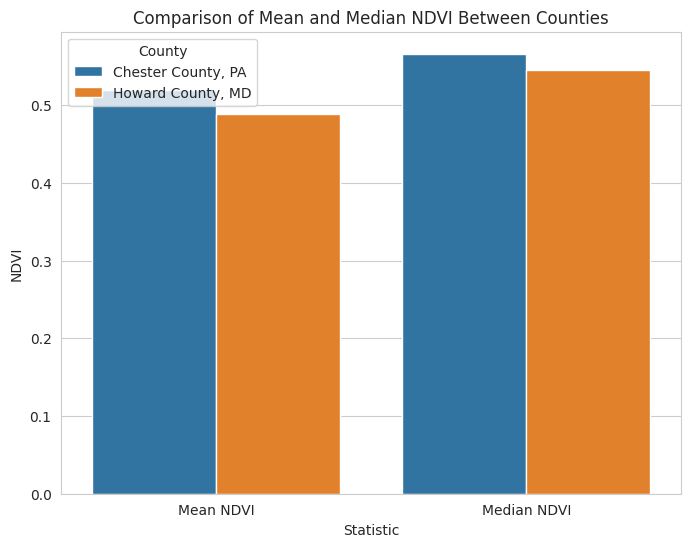

In [44]:
# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Melt the DataFrame for easier plotting
df_melted = df_ndvi.melt(id_vars='County', value_vars=['Mean NDVI', 'Median NDVI'],
                         var_name='Statistic', value_name='NDVI')

# Create a bar plot
plt.figure(figsize=(8,6))
sns.barplot(x='Statistic', y='NDVI', hue='County', data=df_melted)
plt.title('Comparison of Mean and Median NDVI Between Counties')
plt.ylabel('NDVI')
plt.show()


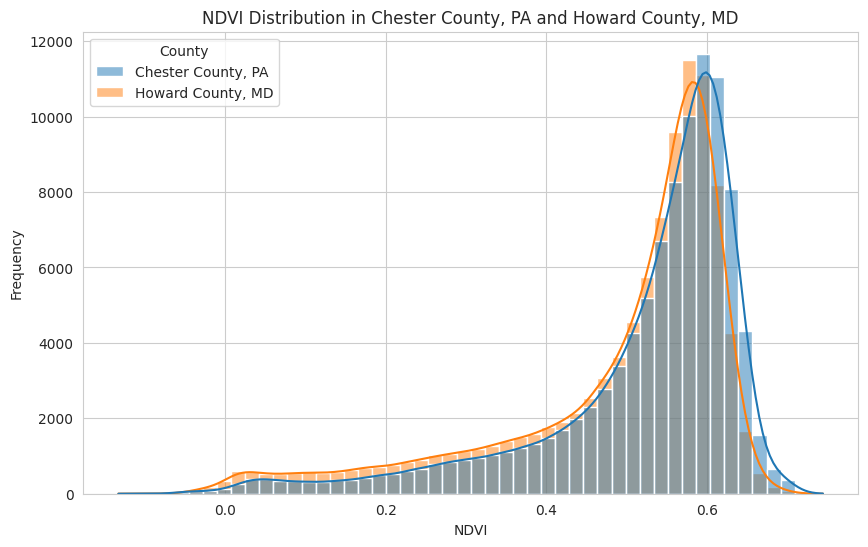

In [45]:
# Function to extract NDVI values as NumPy arrays
def extract_ndvi_values(ndvi_image, roi):
    # Define parameters
    scale = 10  # Sentinel-2 NDVI scale in meters
    max_pixels = 1e13

    # Get the list of NDVI values
    ndvi_list = ndvi_image.sample(
        region=roi,
        scale=scale,
        numPixels=100000,  # Adjust as needed
        geometries=False
    ).aggregate_array('NDVI').getInfo()

    return ndvi_list

# Extract NDVI values
ndvi_values_chester = extract_ndvi_values(ndvi_chester, chester_pa)
ndvi_values_howard = extract_ndvi_values(ndvi_howard, howard_md)

# Create DataFrames
df_chester_ndvi = pd.DataFrame({'NDVI': ndvi_values_chester, 'County': 'Chester County, PA'})
df_howard_ndvi = pd.DataFrame({'NDVI': ndvi_values_howard, 'County': 'Howard County, MD'})

df_combined_ndvi = pd.concat([df_chester_ndvi, df_howard_ndvi], ignore_index=True)

# Plot histograms
plt.figure(figsize=(10,6))
sns.histplot(data=df_combined_ndvi, x='NDVI', hue='County', kde=True, bins=50)
plt.title('NDVI Distribution in Chester County, PA and Howard County, MD')
plt.xlabel('NDVI')
plt.ylabel('Frequency')
plt.show()
